In [2]:
# Create network with Keras
from keras.models import Sequential
from keras.layers import Dense
import keras
import numpy 
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Using TensorFlow backend.


In [3]:
# Read all files in path and concatenate them (Is it a good pratice?)
path =r'../IAmelodyDNN' # use your path
allFiles = glob.glob(path + "/*features.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=None)
    list_.append(df)
frame = pd.concat(list_)

print(frame.shape)

(3242, 513)


In [4]:
df1=pd.read_csv("MusicDelta_Rockabilly_MIX.wavfeatures.csv",header=None)
df2=pd.DataFrame.as_matrix(df1)
print (df2.shape)
df2 = df2 - df2.min()
df2 = df2 / df2.max()

df3=pd.read_csv("MusicDelta_Rockabilly_labels.csv",header=None)
df4=pd.DataFrame.as_matrix(df3)
df4 = df4[::2] # Hop size is doubled in features
print (df4.shape)

(1621, 513)
(1621, 1)


1621


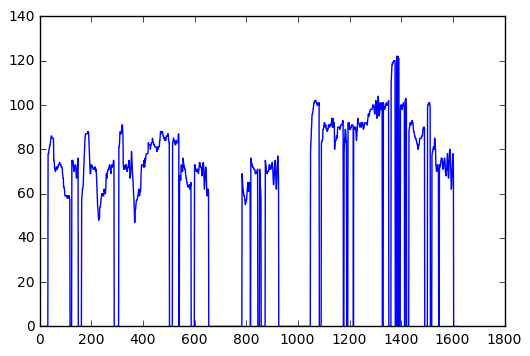

In [5]:
# Mais amostras
df5 = np.zeros(shape=(df2.shape[0],1))
df5[:df4.shape[0],:] = df4

print (df5.shape[0])
plt.plot(np.arange(len(df5)),df5)#, cmap=plt.get_cmap("Reds"))
plt.show()

(1621, 513) (1621, 1)
(1156, 513) (1156, 1)
[[ 78.]
 [ 78.]
 [ 78.]
 ..., 
 [ 78.]
 [ 78.]
 [ 72.]]


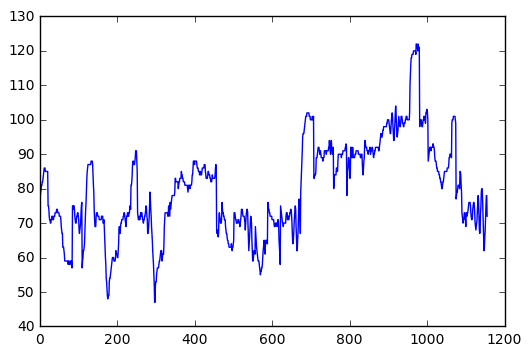

In [6]:
# Remove no vocal frames - train with only vocal frames
no_vocal = np.where(df5[:,0] < 1)
   
print (df2.shape, df5.shape)



for i in reversed(no_vocal):
    df2 = numpy.delete(df2, i, axis=0)
    df5 = numpy.delete(df5, i, axis=0)
    
print (df2.shape, df5.shape)
print (df5)
plt.plot(np.arange(len(df5)),df5)#, cmap=plt.get_cmap("Reds"))
plt.show()

In [7]:
## Train and test data
X = df2
Y = keras.utils.to_categorical(df5, num_classes=193)
x_test = np.random.random((100, 513))
y_test = keras.utils.to_categorical(np.random.normal(80, 20, size=(100, 1)), num_classes=193)

print (X.shape, Y.shape)

# create model
model = Sequential()
model.add(Dense(500, input_dim=513, activation='sigmoid'))
model.add(Dense(500, activation='sigmoid'))
model.add(Dense(193, activation='softmax'))

(1156, 513) (1156, 193)


In [8]:
print (X.shape, df2.shape)
print (Y.shape, df5.shape)

(1156, 513) (1156, 513)
(1156, 193) (1156, 1)


In [9]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# Fit the model
model.fit(X, Y, epochs=10, batch_size=10, validation_data=[x_test, y_test])

Train on 1156 samples, validate on 100 samples
Epoch 1/10
1156/1156 [==============================] - 5s - loss: 0.0265 - acc: 0.9948 - val_loss: 0.0341 - val_acc: 0.9948

In [11]:
# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1152/1156 [============================>.] - ETA: 0s 192/1156 [===>..........................] - ETA: 0s
acc: 99.55%


In [12]:
# calculate predictions
predictions = model.predict(X)

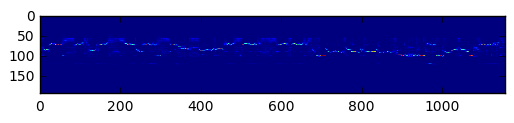

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


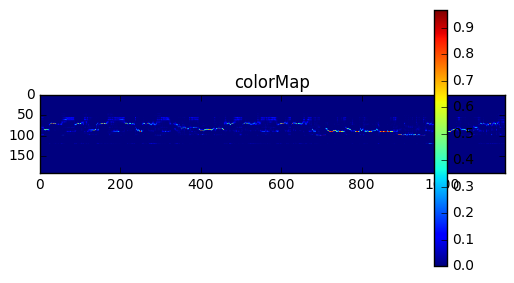

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the grid
plt.imshow(np.transpose(predictions))#,cmap=plt.get_cmap("Reds"))
plt.show()

fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(np.transpose(predictions))
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

In [13]:
print(predictions.min())

1.20934e-10


In [14]:
## Viterbi tracking

In [15]:
def viterbi(obs, states, start_p, trans_p, emit_p):

    V = [{}]

    for st in states:

        V[0][st] = {"prob": start_p[st] * emit_p[st][obs[0]], "prev": None}

    # Run Viterbi when t > 0

    for t in range(1, len(obs)):

        V.append({})

        for st in states:

            max_tr_prob = max(V[t-1][prev_st]["prob"]*trans_p[prev_st][st] for prev_st in states)

            for prev_st in states:

                if V[t-1][prev_st]["prob"] * trans_p[prev_st][st] == max_tr_prob:

                    max_prob = max_tr_prob * emit_p[st][obs[t]]

                    V[t][st] = {"prob": max_prob, "prev": prev_st}

                    break

    opt = []

    # The highest probability

    max_prob = max(value["prob"] for value in V[-1].values())

    previous = None

    # Get most probable state and its backtrack

    for st, data in V[-1].items():

        if data["prob"] == max_prob:

            opt.append(st)

            previous = st

            break

    # Follow the backtrack till the first observation

    for t in range(len(V) - 2, -1, -1):

        opt.insert(0, V[t + 1][previous]["prev"])

        previous = V[t + 1][previous]["prev"]


    #print ('The steps of states are ' + ' '.join(opt) + ' with highest probability of %s' % max_prob)
    #print (opt)
    return V

def dptable(V):

    # Print a table of steps from dictionary

    yield " ".join(("%12d" % i) for i in range(len(V)))

    for state in V[0]:

        yield "%.7s: " % state + " ".join("%.7s" % ("%f" % v[state]["prob"]) for v in V)

In [19]:
import numpy as np

tr_mtx = np.zeros((193,193))
for i in range(193):
    for j in range(193):
        tr_mtx[i,j] = 10**(-np.abs(int(i/8)-int(j/8)))

In [20]:
tr_mtx_normed = tr_mtx / tr_mtx.sum(axis=0)


In [21]:
tr_dic = {}
for i in range(193):
    tr_dic[i] = {}
    for j in range(193):
        tr_dic[i][j] = tr_mtx_normed[i][j]

In [22]:
start_dic= {}
for i in range(193):
    start_dic[i] = 1

In [25]:
obs = np.argmax(np.transpose(predictions).tolist(), axis=0)
states = np.arange(193)
start_p = start_dic
trans_p = tr_dic
emit_p = tr_dic

In [21]:
result = viterbi(obs, states, start_p, trans_p, emit_p)

In [1]:
# Plot the grid
#plt.plot(np.arange(len(result)),result)#, cmap=plt.get_cmap("Reds"))
#plt.show()
#print (result)

In [14]:
result = viterbi(np.argmax(np.transpose(predictions), axis=0).tolist(), 0.99,0.9)

ImportError: No module named 'scipy.weave'

In [34]:
import numpy as np

'''
N: number of hidden states
'''
class Decoder(object):
    def __init__(self, initialProb, transProb, obsProb):
        self.N = initialProb.shape[0]
        self.initialProb = initialProb
        self.transProb = transProb
        self.obsProb = obsProb
        assert self.initialProb.shape == (self.N, 1)
        assert self.transProb.shape == (self.N, self.N)
        assert self.obsProb.shape[0] == self.N

    def Obs(self, obs):
        return self.obsProb[:, obs, None]

    def Decode(self, obs):
        trellis = np.zeros((self.N, len(obs)))
        backpt = np.ones((self.N, len(obs)), 'int32') * -1

        # initialization
        trellis[:, 0] = np.squeeze(self.initialProb * self.Obs(obs[0]))

        for t in range(1, len(obs)):
            trellis[:, t] = (trellis[:, t-1, None].dot(self.Obs(obs[t]).T) * self.transProb).max(0)
            backpt[:, t] = (np.tile(trellis[:, t-1, None], [1, self.N]) * self.transProb).argmax(0)
        # termination
        tokens = [trellis[:, -1].argmax()]
        for i in range(len(obs)-1, 0, -1):
            tokens.append(backpt[tokens[-1], i])
        return tokens[::-1]

In [45]:
start_p = np.ones(193).reshape(193,1)
start_p = start_p/193
trans_p = tr_mtx_normed
emit_p = tr_mtx_normed
result = Decoder(start_p, trans_p, emit_p)

In [ ]:
x = result.Decode(obs)

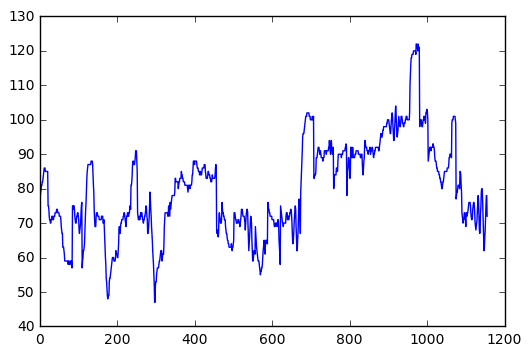

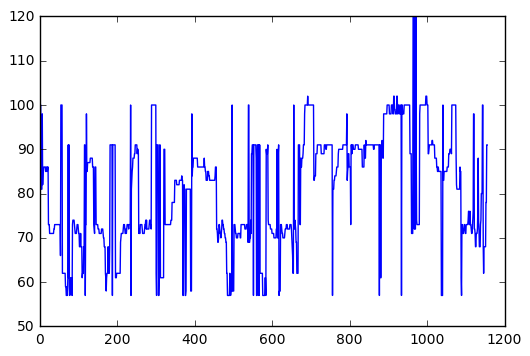

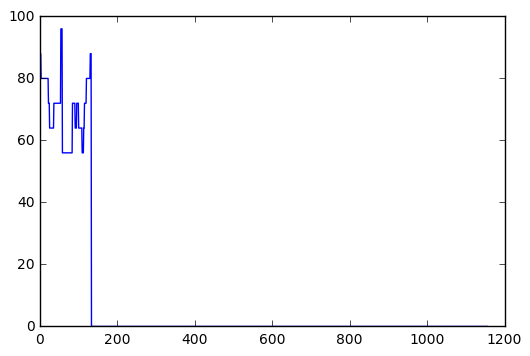

In [ ]:
# Plot the grid

plt.plot(np.arange(len(df5)),df5)#, cmap=plt.get_cmap("Reds"))
plt.show()
pre = np.argmax(np.transpose(predictions), axis=0).tolist()
pre[pre==0] = None
plt.plot(np.arange(len(pre)),pre)#, cmap=plt.get_cmap("Reds"))
plt.show()
plt.plot(np.arange(len(x)),x)#, cmap=plt.get_cmap("Reds"))
plt.show()

In [25]:
print (df5.min())

0.0


In [17]:
obs = ('normal', 'cold', 'dizzy', 'cold')
states = ('Healthy', 'Fever')
start_p = {'Healthy': 0.6, 'Fever': 0.4}
trans_p = {
   'Healthy' : {'Healthy': 0.7, 'Fever': 0.3},
   'Fever' : {'Healthy': 0.4, 'Fever': 0.6}
   }
emit_p = {
   'Healthy' : {'normal': 0.5, 'cold': 0.4, 'dizzy': 0.1},
   'Fever' : {'normal': 0.1, 'cold': 0.3, 'dizzy': 0.6}
   }

viterbi(obs, states, start_p, trans_p, emit_p)

['Healthy', 'Healthy', 'Fever', 'Fever']
